# Summary
**Settings parameters**: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data
test_fun: underlying function


**Current Test** \
p=1, x4, x04, test_fun1

**Tests**:
1. p=1 or p=2, x=x1, x0=x01, test_fun=test_fun1 \
    narrow pdf, some quantile comp hard ==> bracketing interval $[0,5]$ works well!
2. p=1, x2, x02, test_fun2 \
    pdf very large near 0, so 2.5% quantile estimation gives negative estimate, which is not a good guess and also indicates that 2.5% quantile is extremely small. 
3. p=1, x3, x03, test_fun3 \
    narrow pdf, median hard ==> bracketing interval $[0,5]$ works well! \
    cdf(0) = 0.02898, 2.5% quantile doesn't exist
4. p=1, x4, x04, test_fun1 \
    two-peak pdf, can do mode, some quantile, but two-peak makes computation of CI (equal and narrow) super hard.
    
**Conclusion**:
1. Narrow pdf is the hardest case. Even if quant0 provides relatively good initial guess, find_zero easily goes to negative region, where CDF is not defined. \
Solution: bracketing interval works better than initial guess in root-finding
2. cdf(0) > 2.5% makes 2.5% quantile doesn't exist          
3. Weird shape: large pdf near 0 and two-peak pdf should be carefully treated. 
 

In [16]:
include("../btg.jl")
include("../statistics.jl")
using Printf

In [2]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [3]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 2

# training
x1 = [0., .5, .8, 1., 1.6, 2.]
x2 = [0., .5, .8, 1., 2.]
x3 = [0., 0.3, 0.8, 1., 1.6, 2.]
x4 = [0., 1., 1.6, 2.]

# testing
x01 = .25
x02 = 1.2
x03 = .5
x04 = .6

# underlying 1d function
test_fun1(x) = sin(x) + 1.1
test_fun2(x) = sin(15*x) + (x^2+1) 
test_fun3(x) = log(x^2+1) + (x^3+x+1)/(exp(x)) 

test_fun3 (generic function with 1 method)

In [4]:
p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x4 # choose training data 
x0 = x04 # choose testing data
test_fun = test_fun1 # choose underlying function

x = reshape(x, size(x, 1), 1)
x0 = reshape([x0], 1, 1) 
Fx = covariate_fun(x, p)
y = reshape(test_fun.(x), size(x, 1))
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [10. 1000.]
rangeλ = [-1. 1.]

Fx0 = covariate_fun(x0, p)
y0_true = reshape(test_fun.(x0), 1)./ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")

Prediction at x0 = [0.6]
Covariates at x0: [1.0]
Should expect peak near [0.792847876818219]


In [11]:
btg1 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["SparseGrid", "Gaussian"])
(pdf1_raw, cdf1_raw, dpdf1_raw, quantInfo1_raw) = solve(btg1);

In [12]:
btg2 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["Gaussian", "Gaussian"])
(pdf2_raw, cdf2_raw, dpdf2_raw, quantInfo2_raw) = solve(btg2);

In [13]:
btg3 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["QuasiMonteCarlo", "QuasiMonteCarlo"])
(pdf3_raw, cdf3_raw, dpdf3_raw, quantInfo3_raw) = solve(btg3);

In [14]:
btg4 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["SparseGrid", "Gaussian"])
(pdf4_raw, cdf4_raw, dpdf4_raw, quantInfo4_raw) = solve(btg4);

In [9]:
btg5 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["SparseCarlo", "SparseCarlo"])
(pdf5_raw, cdf5_raw, dpdf5_raw, quantInfo5_raw) = solve(btg5);

# Statistics

In [18]:
pdf1, cdf1, dpdf1, quantbound1, support1 = 
    pre_process(x0, Fx0, pdf1_raw, cdf1_raw, dpdf1_raw, quantInfo1_raw)

pdf2, cdf2, dpdf2, quantbound2, support2 = 
    pre_process(x0, Fx0, pdf2_raw, cdf2_raw, dpdf2_raw, quantInfo2_raw)

pdf3, cdf3, dpdf3, quantbound3, support3 = 
    pre_process(x0, Fx0, pdf3_raw, cdf3_raw, dpdf3_raw, quantInfo3_raw)

pdf4, cdf4, dpdf4, quantbound4, support4 = 
    pre_process(x0, Fx0, pdf4_raw, cdf4_raw, dpdf4_raw, quantInfo4_raw);

pdf5, cdf5, dpdf5, quantbound5, support5 = 
    pre_process(x0, Fx0, pdf5_raw, cdf5_raw, dpdf5_raw, quantInfo5_raw);

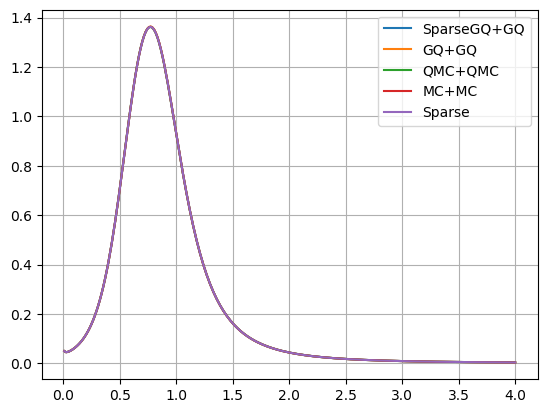

In [22]:
# see briefly the shape of pdf
xgrid = range(1e-2, stop=4, step = 0.015)
plot(xgrid, pdf1.(xgrid), label = "SparseGQ+GQ")
plot(xgrid, pdf2.(xgrid), label = "GQ+GQ")
plot(xgrid, pdf3.(xgrid), label = "QMC+QMC")
plot(xgrid, pdf4.(xgrid), label = "MC+MC")
plot(xgrid, pdf5.(xgrid), label = "Sparse")
PyPlot.legend()
PyPlot.grid()

In [ ]:
px=.6
quant1, err_quant1, quant_bound1 = quantile(cdf1, quantbound1, support1; p=px)
median1, err_med1, med_bound1 =  quantile(cdf1, quantbound1, support1)
mode1 = mode(pdf1, support1)
CI1, wp1, err_CI1 = credible_interval(cdf1, quantbound1, support1;
                                mode=:equal, wp=.95)

quant2, err_quant2, quant_bound2 = quantile(cdf2, quantbound2, support2; p=px)
median2, err_med2, med_bound2 =  quantile(cdf2, quantbound2, support2)
mode2 = mode(pdf2, support2)
CI2, wp2, err_CI2 = credible_interval(cdf2, quantbound2, support2;
                                mode=:equal, wp=.95)

quant3, err_quant3, quant_bound3 = quantile(cdf3, quantbound3, support3; p=px)
median3, err_med3, med_bound3 =  quantile(cdf3, quantbound3, support3)
mode3 = mode(pdf3, support3)
CI3, wp3, err_CI3 = credible_interval(cdf3, quantbound3, support3;
                                mode=:equal, wp=.95)

quant4, err_quant4, quant_bound4 = quantile(cdf4, quantbound4, support4; p=px)
median4, err_med4, med_bound4 =  quantile(cdf4, quantbound4, support4)
mode4 = mode(pdf4, support4)
CI4, wp4, err_CI4 = credible_interval(cdf4, quantbound4, support4;
                                mode=:equal, wp=.95)

quant5, err_quant5, quant_bound5 = quantile(cdf5, quantbound5, support5; p=px)
median5, err_med5, med_bound5 =  quantile(cdf5, quantbound5, support5)
mode5 = mode(pdf5, support5)
CI5, wp5, err_CI5 = credible_interval(cdf5, quantbound5, support5;
                                mode=:equal, wp=.95)

println("Summary:")
println("            Median   Mode     $px quantile    Credible Intervel")
println("Sparse+GQ   $(@sprintf("%.5f", median1))  $(@sprintf("%.5f", mode1))  $(@sprintf("%.5f", quant1))         [$(@sprintf("%.4f", CI1[1])), $(@sprintf("%.4f", CI1[2]))] ")
println("GQ+GQ       $(@sprintf("%.5f", median2))  $(@sprintf("%.5f", mode2))  $(@sprintf("%.5f", quant2))         [$(@sprintf("%.4f", CI2[1])), $(@sprintf("%.4f", CI2[2]))]")
println("QMC+QMC     $(@sprintf("%.5f", median3))  $(@sprintf("%.5f", mode3))  $(@sprintf("%.5f", quant3))         [$(@sprintf("%.4f", CI3[1])), $(@sprintf("%.4f", CI3[2]))]")
println("MC+MC       $(@sprintf("%.5f", median4))  $(@sprintf("%.5f", mode4))  $(@sprintf("%.5f", quant4))         [$(@sprintf("%.4f", CI4[1])), $(@sprintf("%.4f", CI4[2]))]")
println("Sparse      $(@sprintf("%.5f", median5))  $(@sprintf("%.5f", mode5))  $(@sprintf("%.5f", quant5))         [$(@sprintf("%.4f", CI5[1])), $(@sprintf("%.4f", CI5[2]))]")
println("Credible level: $wp1")

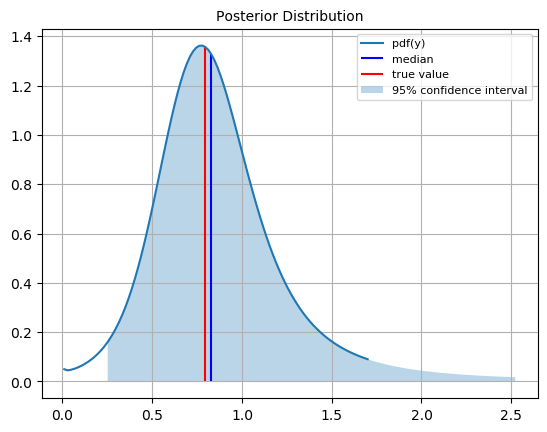

PyObject Text(0.5, 1, 'Posterior Distribution')

In [74]:
# plot all results
plot_distribution(pdf1, median1, mode1, y0_true; CI = CI1)

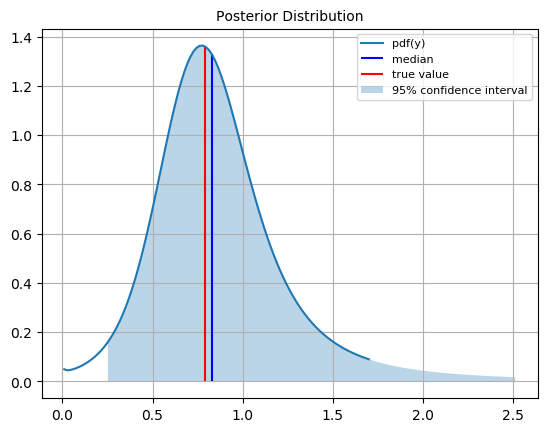

PyObject Text(0.5, 1, 'Posterior Distribution')

In [75]:
plot_distribution(pdf2, median2, y0_true; CI = CI2)

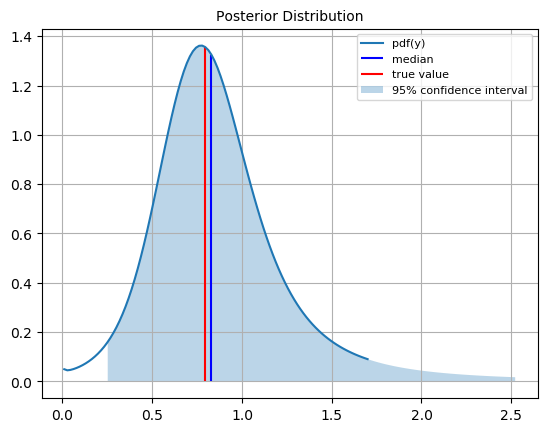

PyObject Text(0.5, 1, 'Posterior Distribution')

In [76]:
plot_distribution(pdf3, median3, y0_true; CI = CI3)

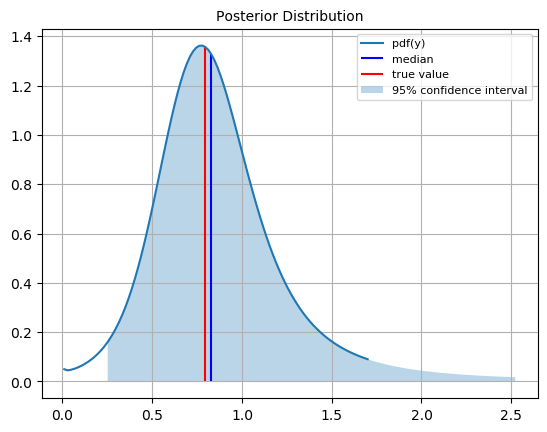

PyObject Text(0.5, 1, 'Posterior Distribution')

In [77]:
plot_distribution(pdf4, median4, y0_true; CI = CI4)